# Unfolding with RooUnfold 3: Response

Now that we have a better handle on the unfolding problem and how the various methods included in RooUnfold perform the unfolding operation to get the estimators used in our analysis, this excercise demonstrates the application of the problem to a slightly more complex analysis. In many cases the problems inherent in unfolding can be predicted before we ever look at an unfolded distribution.

In [1]:
import ROOT
import numpy as np
ROOT.RooRandom.randomGenerator().SetSeed(666)

In file included from input_line_33:1:
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/dlfcn.h:64:37: warning: unknown platform 'driverkit' in availability macro [-Wavailability]
extern int dlclose(void * __handle) __DYLDDL_DRIVERKIT_UNAVAILABLE;
                                    ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/dlfcn.h:44:41: note: expanded from macro '__DYLDDL_DRIVERKIT_UNAVAILABLE'
 #define __DYLDDL_DRIVERKIT_UNAVAILABLE __API_UNAVAILABLE(driverkit)
                                        ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/Availability.h:419:190: note: expanded from macro '__API_UNAVAILABLE'
    #define __API_UNAVAILABLE(...) __API_UNAVAILABLE_GET_MACRO(__VA_ARGS__,__API_UNAVAILABLE7,__API_UNAVAILABLE6,__API_UNAVAILABLE5,__API_UNAVAILABLE4,__API_UNAVAILABLE3,__API_UNAVAILABLE2,__API_UNAVAILABLE1, 0)(__VA_ARGS__)
                                                                                           

Welcome to JupyROOT 6.26/04

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



## Generating example data for a more realistic problem


### Smearing

First we look at the smearing function, typically this operation is performed internally by some dedicated detector simulation. In contrast to the other two problems however this function leaves a little more room for introducing systematics at a later stage.

In [2]:
def smear(xtrue, np3, np2):
    xeff = np3 - abs(xtrue)/600.
    x = ROOT.gRandom.Rndm()
    if x > xeff:
        return -99999
    xsmear = ROOT.gRandom.Gaus(0, np2 * ROOT.sqrt(xtrue/30))
    return xtrue + xsmear

We will have a few pieces of information to parse here so let's first store a few important parameters for generating our data. 

In [3]:
binning = np.array([0,2,4,6,8,10,12,14,18,25,35,45,60], 'd')
n_bins = 12
total_scale = 0.01

n_MC_sig_events = 1000000.
n_MC_bkg_events = 1000000.

n_data_sig_events = 10000.
n_data_bkg_events = 30000.

sig_lumiScale = n_data_sig_events/n_MC_sig_events
bkg_lumiScale = n_data_bkg_events/n_MC_bkg_events

### Generate Some Data

Next we generate data from probability distributions defined by RooFit (but in your analysis this will likely be different - we are still setting up the example).

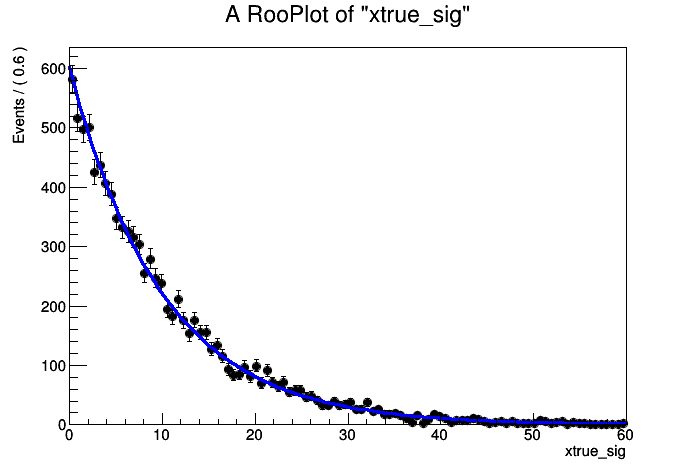

In [4]:
# Nuisance parameter 4 affecting the bkg curve.
NP4_val = -0.09
# Nuisance parameter 5 affecting the sig curve.
NP5_val = -0.1

# define RooFit variables
xtrue_sig = ROOT.RooRealVar("xtrue_sig","xtrue_sig",0,60)
xtrue_bkg = ROOT.RooRealVar("xtrue_bkg","xtrue_bkg",0,60)
lambda_sig = ROOT.RooRealVar("lambda_sig", "lambda_sig", NP5_val)
lambda_bkg = ROOT.RooRealVar("lambda_bkg", "lambda_bkg", NP4_val)

# create pdfs
sigPDF = ROOT.RooExponential("sigPDF","sigPDF", xtrue_sig, lambda_sig)
bkgPDF = ROOT.RooExponential("bkgPDF","bkgPDF", xtrue_bkg, lambda_bkg)

# generate events from pdfs
MC_sig_Events = ROOT.RooDataSet = sigPDF.generate(xtrue_sig,n_MC_sig_events)
MC_sig_test_Events = ROOT.RooDataSet = sigPDF.generate(xtrue_sig,n_MC_sig_events)
data_sig_Events = ROOT.RooDataSet = sigPDF.generate(xtrue_sig,n_data_sig_events)
MC_bkg_Events = ROOT.RooDataSet = bkgPDF.generate(xtrue_bkg,n_MC_bkg_events)
data_bkg_Events = ROOT.RooDataSet = bkgPDF.generate(xtrue_bkg,n_data_bkg_events)

c1 = ROOT.TCanvas()
frame = xtrue_sig.frame(100)
data_sig_Events.plotOn(frame)
sigPDF.plotOn(frame)
frame.Draw()
c1.Draw()

### Convert data to histograms

Usually the unfolding step of your analysis will start at the histogram stage. So let's get our data into some histograms.

In [5]:
truthHist = ROOT.TH1D("truth_nom", "truth_nom", n_bins, binning)
recoHist = ROOT.TH1D("reco_nom", "reco_nom", n_bins, binning)
recoBkgHist = ROOT.TH1D("reco_bkg_nom", "reco_nom", n_bins,binning)
responseHist = ROOT.TH2D("response_nom", "response_nom", n_bins, binning, n_bins, binning)
truthTestHist = ROOT.TH1D ("truthnom_test", "truthnom_test", n_bins, binning)
dataHist = ROOT.TH1D("reconom_test", "reconom_test", n_bins, binning)

First we need to introduce some additional parameters that govern the experimental paramters. 

In [6]:
# Nuisance parameter 1 affecting a scale factor.
NP1_val = 1.

# Nuisance parameter 2 affecting the smearing.
NP2_val = 4.

# Nuisance parameter 3 affecting the efficiency.
NP3_val = 0.95

# and a scale factor to compare MC and data
total_scale = 0.01

Unfortunately filling these histograms from RooDataSets is not the most elegant proceedure.

In [7]:
for event in range(int(n_MC_sig_events)):
    xtrue_sig_val = ROOT.RooRealVar(MC_sig_Events.get(event).find(xtrue_sig.GetName())).getVal()
    xreco_sig_val = smear(xtrue_sig_val, NP3_val, NP2_val)
    truthHist.Fill(xtrue_sig_val, sig_lumiScale * total_scale)
    if xreco_sig_val != -99999:
        recoHist.Fill(xreco_sig_val, sig_lumiScale * NP1_val * total_scale)
        responseHist.Fill(xreco_sig_val, xtrue_sig_val, sig_lumiScale * NP1_val * total_scale)

for event in range(int(n_MC_bkg_events)):
    xtrue_bkg_val = ROOT.RooRealVar(MC_bkg_Events.get(event).find(xtrue_bkg.GetName())).getVal()
    xreco_bkg_val = smear(xtrue_bkg_val, NP3_val, NP2_val)

    if xreco_bkg_val != -99999:
        recoBkgHist.Fill(xreco_bkg_val, bkg_lumiScale * NP1_val * total_scale)

Now for our "data" we repeat the proceedure again

In [8]:
for event in range(int(n_data_sig_events)):
    xtrue_val = ROOT.RooRealVar(data_sig_Events.get(event).find(xtrue_sig.GetName())).getVal()
    xreco_val = smear(xtrue_val, NP3_val, NP2_val)

    if xreco_val != -99999:
        dataHist.Fill(xreco_val, total_scale)

for event in range(int(n_data_bkg_events)):
    xtrue_val = ROOT.RooRealVar(data_bkg_Events.get(event).find(xtrue_bkg.GetName())).getVal()
    xreco_val = smear(xtrue_val, NP3_val, NP2_val)

    if xreco_val != -99999:
        dataHist.Fill(xreco_val, total_scale)
        
for event in range(int(n_MC_sig_events)):
    xtrue_sig_val = ROOT.RooRealVar(MC_sig_Events.get(event).find(xtrue_sig.GetName())).getVal()
    truthTestHist.Fill(xtrue_sig_val, sig_lumiScale*total_scale)

and visualise

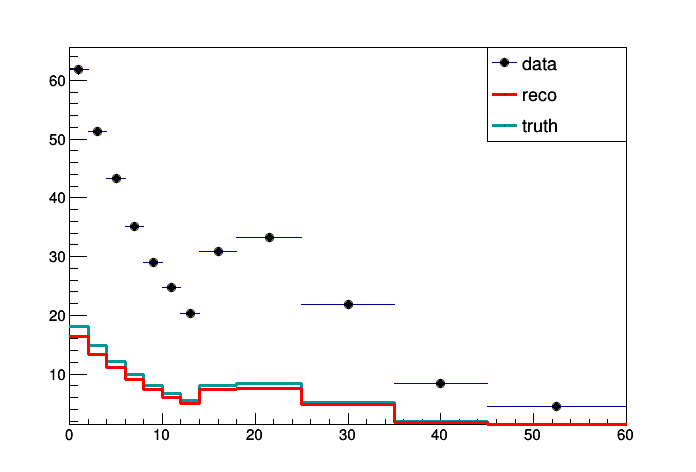

In [9]:
c1 = ROOT.TCanvas()
dataHist.SetMarkerStyle(20)
dataHist.SetStats(0)
dataHist.SetTitle("")
dataHist.Draw()
truthHist.SetLineColor(ROOT.kCyan+2)
truthHist.SetLineWidth(3)
truthHist.Draw("Hsame")
recoHist.SetLineColor(ROOT.kRed)
recoHist.SetLineWidth(3)
recoHist.Draw("Hsame")
legend = ROOT.TLegend(.7,.7,.9,.9)
legend.AddEntry(dataHist,"data")
legend.AddEntry(recoHist,"reco")
legend.AddEntry(truthHist,"truth")
legend.Draw()
c1.Draw()

## The `RooUnfoldSpec` class

The `RooUnfoldSpec` class completely defines the unfolding problem in a single computationally efficient interface. 

In [10]:
spec = ROOT.RooUnfoldSpec("unfold", "unfold",
                          truthHist,"obs_truth",
                          recoHist,"obs_reco",
                          responseHist,
                          recoBkgHist,
                          dataHist,
                          True,0.0005)

The parameters are as follows:
- `name` and `title` - as with any other root object
- `truth hist` and `truth observable` - This is because RooFit is used to define the range the unfolding is valid for
- `reco hist` and `reco observable` - as above
- `response hist` - we are unfolding after all
- `background hist` - optional
-  `includeUnderflowOverflow`, `errorThreshold` as described

The `RooUfoldSpec` can be used to provide the same unfolding operation as before, but provides a more correct handling of the propagation of uncertainties through the transformation.

In [11]:
unfolding = spec.makeFunc(ROOT.RooUnfolding.kBayes, 10)
Hunfolded = unfolding.unfolding().Vunfold()
Hunfolded.Print() # This should be a histogram.


Vector (14)  is as follows

     |        1  |
------------------
   0 |0 
   1 |17.7647 
   2 |15.4967 
   3 |13.162 
   4 |9.40125 
   5 |7.77911 
   6 |6.98961 
   7 |5.48679 
   8 |7.66938 
   9 |8.86972 
  10 |4.95129 
  11 |1.34767 
  12 |1.35409 
  13 |0 



## Assessing the nature of your problem

In the previous examples we discussed the nature of the unfolding problem and how regularisation can be used to alieviate various pathologies therein. A clear insight into many of these problems however can be deduced from inspecting the problem setup. To construct an unfolding problem we only need a response matrix and a data histogram. The truth and reco histograms are used to calculate the number of events we expect in data that arent in truth and vice versa by comparing with the counts of the response histogram. From only this information we can inspect the purity, the efficiency, and the response matrix itself.

First we define a small helper function:

In [12]:
def make_hist(vec, template, title="", errors=None):
    tmp = template.Clone(title)
    tmp.SetTitle(title)
    for b in range(tmp.GetNbinsX()+1):
        if np.isnan(vec[b]): vec[b] =0
        tmp.SetBinContent(b,vec[b])
        if errors: tmp.SetBinError(b,errors[b])
        else: tmp.SetBinError(b,0)
    tmp.SetStats(0)
    tmp.SetLineColor(1)
    return tmp

## Inspecting the response matrix

A standard practice that perhaps the most impact on an analysis is inspecting the response matrix. Common wisdom tells novice analysers to inspect the response matrix for the dreaded "off-diagonal" elements. These represent the migrations with small singular values that can lead to large variances. Though as we've seen this is perhaps an oversimplification as we can visualise with our truncated SVD. 
![](response.gif)

What we really care about is the "smoothness" of the reponse as a function but the easiest we to do this is to inspect the reponse matrix.

So lets look at the response matrix!

The first step is the two-dimensional detector response that maps truth events to reco:

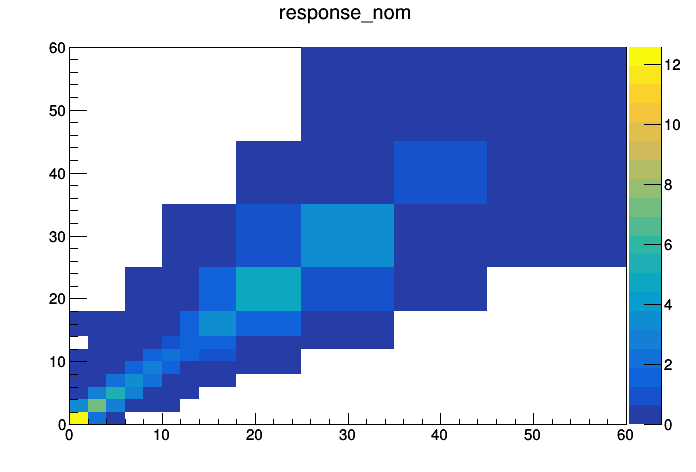

In [13]:
responseHist.SetStats(0)
c1 = ROOT.TCanvas()
responseHist.Draw("colz")
c1.Draw()

However with variable bin widths and steeply falling distributions this can be difficult to spot the key components. It is worth remembering here that in most unfolding algorithms the response matrix $R$ is the probability for an event produced in bin $i$ in truth is reconstructed in each bin $j$ in reco such that:

$$
\nu  = R\mu
$$

where $\mu$ is the truth bin contents and $\nu$ is the reco distribution. With this in hand we can define a helper function to convert this histogram into the probability matrix:

In [14]:
def inspect_response(responseHist, truthHist):
    tmp = ROOT.TH2D("prob", "prob",
                    responseHist.GetNbinsX(), 0, responseHist.GetNbinsX(), 
                    responseHist.GetNbinsY(), 0, responseHist.GetNbinsY())
    tmp.SetStats(0)
    for i in range(responseHist.GetNbinsX()+1):
        for j in range(responseHist.GetNbinsY()+1):
            if truthHist.GetBinContent(j) > 0:
                tmp.SetBinContent(i,j,responseHist.GetBinContent(i,j)/truthHist.GetBinContent(j))
            else:

                tmp.SetBinContent(i,j,responseHist.GetBinContent(i,j))
    return tmp

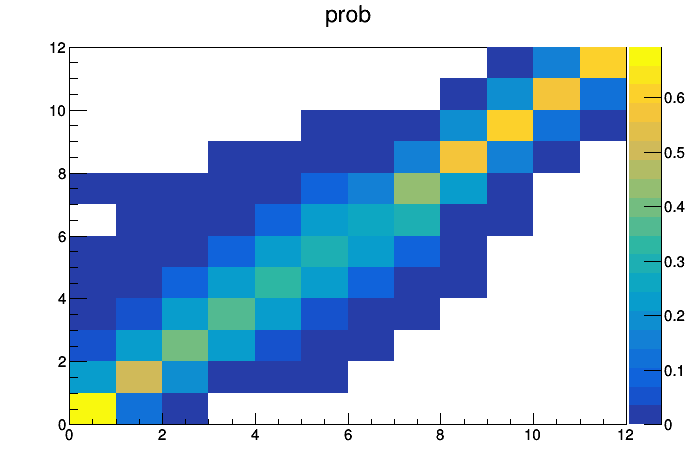

In [15]:
prob = inspect_response(responseHist, truthHist)
c1 = ROOT.TCanvas()
prob.Draw("colz")
c1.Draw()

This approach makes it easier to see that in the central few bins, particularly the 12-18 GeV mark, and also the highest bin, there are some striking features that might lead to problems in the unfolding. 

But how to fix these? Regularisation?! Not yet, remeber that in regularisation we introduce a bias that we would like to avoid. Already now we can help alieviate this by using a smarter choice of binning.

### Purity and Efficiency

The purity is related to how often an event migrates outside of the corresponding truth bin when measured. It is defined as the ratio of the diagonal in the response histogram to the number of events in the reco histogram. The more migrations there are the lower the purity. Remember also that the more complex the mapping between the truth and reco the more regularisation you are likely to need. If the purity is 100% you likely don't need to unfold, however if it is too low you might need apply a lot of regularisation (and introduce a lot of bias). The efficiency is the events that, although generated in truth are not reconstructed and therefore don't end up in the response matrix these are accounted for after unfolding. These two quantites can be balanced by changining the binning and the binning range.

First we retrieve the RooUnfoldResponse object that stores the information we need:

In [16]:
response = spec.makeFunc(ROOT.RooUnfolding.kInvert).unfolding().response()

and from this the desired vectors

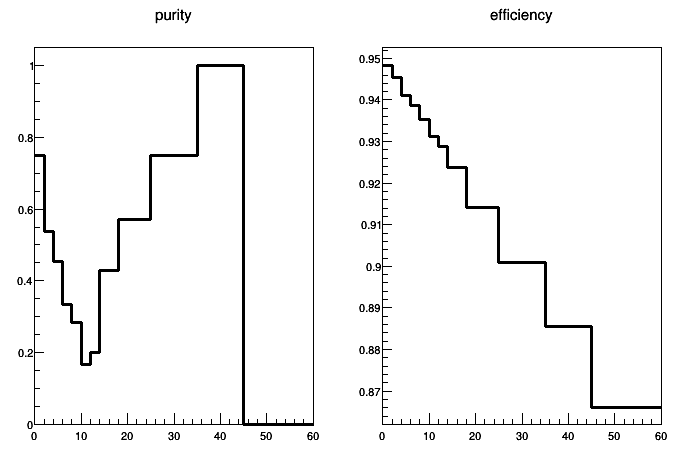

In [17]:
pur_vec = response.Vpurity() # a vector of the purity
eff_vec = response.Vefficiency() # a vector of the efficiency

c1 = ROOT.TCanvas()
c1.Divide(2,1,.0001,0.0001)
c1.cd(1)
purity = make_hist(pur_vec, recoHist, "purity")
purity.Draw()
c1.cd(2)
efficiency = make_hist(eff_vec, truthHist, "efficiency")
efficiency.Draw()
c1.Draw()

by rebinning we might hope to alieviate some of these patterns. These plots identify the problematic bins, the reponse matrix above suggest which direction you might want shift the bin edge to make it more diagonal.

In [18]:
origingal_binning = np.array([0,2,4,6,8,10,12,14,18,25,35,45,60], 'd')
binning = np.array([0,2,5,8,12,18,25,35,45,60], 'd')
n_bins = 8

truthNew = ROOT.TH1D("truth", "truth_nom", n_bins, binning)
recoNew = ROOT.TH1D("reco", "reco_nom", n_bins, binning)
responseNew = ROOT.TH2D("response", "response_nom", n_bins, binning, n_bins, binning)

for event in range(int(n_MC_sig_events)):
    xtrue_sig_val = ROOT.RooRealVar(MC_sig_Events.get(event).find(xtrue_sig.GetName())).getVal()
    xreco_sig_val = smear(xtrue_sig_val, NP3_val, NP2_val)
    truthNew.Fill(xtrue_sig_val, sig_lumiScale * total_scale)
    if xreco_sig_val != -99999:
        recoNew.Fill(xreco_sig_val, sig_lumiScale * NP1_val * total_scale)
        responseNew.Fill(xreco_sig_val, xtrue_sig_val, sig_lumiScale * NP1_val * total_scale)

We reinitialise the objects with the new binning.

In [19]:
spec_new = ROOT.RooUnfoldSpec("unfold_new", "unfold",
                          truthNew,"obs_truth",
                          recoNew,"obs_reco",
                          responseNew,
                          0,
                          recoNew,
                          True,0.0005) # NB data is now reco and backgrounds are False since they don't effect the response.
response_new = spec_new.makeFunc(ROOT.RooUnfolding.kInvert).unfolding().response()

A general rule of thumb is to aim for at least 50% efficiency and purity in each bin. 

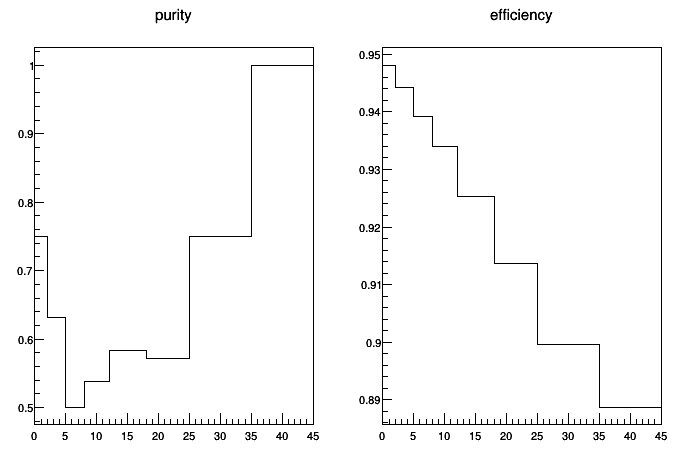

In [20]:
pur_vec = response_new.Vpurity() # a vector of the purity
eff_vec = response_new.Vefficiency() # a vector of the efficiency

c1 = ROOT.TCanvas()
c1.Divide(2,1,.0001,0.0001)
c1.cd(1)
purity = make_hist(pur_vec, recoNew, "purity")
purity.Draw()
c1.cd(2)
efficiency = make_hist(eff_vec, truthNew, "efficiency")
efficiency.Draw()
c1.Draw()